# Neural Forecasting (N-BEATS, TFT) with Darts

This notebook contains neural forecasting experiments using the Darts library (N-BEATS and TFT models). It demonstrates how to prepare multi-series TimeSeries objects, add covariates, scale data, and run backtests.

What this notebook contains:
- Data conversion utilities from pandas to Darts TimeSeries.
- Scaling and covariate construction (past & future covariates).
- Model definitions for N-BEATS (univariate / global) and TFT (multi-horizon with covariates) and training with early stopping.
- Backtesting/historical_forecasts examples and evaluation metrics (MAPE, MAE, RMSE, R^2).

In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.missing_values import fill_missing_values
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib widget

from darts import concatenate, slice_intersect


# Data preparation

## Load data and assign covariates

In [ ]:
# Step 1: Load and preprocess data
data = pd.read_csv("price_vol_temp_inven_mc_merged_cleaned_data.csv", parse_dates=["date"])
data = data.set_index("date").sort_index()

# Cutoff date
cutoff_date_min = pd.to_datetime("2009-01-02") # Remove the first data point of ttf_price
cutoff_date_max = pd.to_datetime("2025-06-20")
data = data[(data.index >= cutoff_date_min) & (data.index <= cutoff_date_max)]

# Choose core target series
target_cols = ["hh_price", "ttf_price", "psv_price", "jkm_price", "pvb_price"]

# Choose relevant covariates with wide enough history
shared_covariates = ["brent_price"]#, "coal_price"]#, "brent_volume"]
covariates = {'hh_price' :[ "ttf_price", "hh_temperature"] + shared_covariates,
              'ttf_price':[ "hh_price", "ttf_temperature"] + shared_covariates,
              'psv_price':[ "hh_price", "ttf_price", "nbp_price", "psv_temperature"] + shared_covariates,
              'jkm_price':[ "hh_price", "ttf_price", "nbp_price", "psv_price", "jkm_temperature"] + shared_covariates,
              'pvb_price':[ "hh_price", "ttf_price", "nbp_price", "psv_price", "jkm_price", "pvb_temperature"] + shared_covariates}

# covariates = {'hh_price' :[ "ttf_price", "hh_temperature"] + shared_covariates,
#               'ttf_price':[ "hh_price", "ttf_temperature"] + shared_covariates,
#               'psv_price':[ "hh_price", "psv_temperature"] + shared_covariates,
#               'jkm_price':[ "hh_price", "jkm_temperature"] + shared_covariates,
#               'pvb_price':[ "hh_price", "pvb_temperature"] + shared_covariates}

covariates = {'hh_price' :[ "hh_temperature"] + shared_covariates,
              'ttf_price':["ttf_temperature"] + shared_covariates,
              'psv_price':["psv_temperature"] + shared_covariates,
              'jkm_price':["jkm_temperature"] + shared_covariates,
              'pvb_price':["pvb_temperature"] + shared_covariates}

# Create TimeSeries objects for each target and covariate
covariate_cols = [col for sublist in covariates.values() for col in sublist]

# covariates = shared_covariates

unique_cols = list(set(target_cols + covariate_cols))

## Generate target, cov, train, test

In [32]:
# Step 2: Convert all cols to Darts TimeSeries
series_dict = {
    col: TimeSeries.from_series(
        data[col].dropna().asfreq('B').interpolate(method='time').astype(np.float32),  # Ensure daily frequency,
        fill_missing_dates=True,
        fillna_value=0,  # Fill missing values with 0
        freq='B'
    )
    for col in unique_cols
}
print('data shapes: ', series_dict['hh_price'].shape, series_dict['ttf_price'].shape, series_dict['psv_price'].shape, \
    series_dict['jkm_price'].shape, series_dict['pvb_price'].shape)

# Step 3: Train-test split and scale series individually
date_split = pd.to_datetime("2024-07-01")
scaler_dict = {}
scaled_train_series = {col: [] for col in unique_cols}
scaled_test_series = {col: [] for col in unique_cols}
for col in unique_cols:
    scaler = Scaler()
    scaled_train_series[col] = scaler.fit_transform(series_dict[col][:date_split])
    scaled_test_series[col] = scaler.transform(series_dict[col][date_split:])
    scaler_dict[col] = scaler

# Step 4: Create target and covariate series: train, validation, and test sets
scaled_target_series_train = [scaled_train_series[col] for col in target_cols]
scaled_target_series_all = [concatenate([scaled_train_series[col], scaled_test_series[col]], ignore_time_axis=True)
                                    for col in target_cols] # for plotting all data together
# Validation and test sets
date_start, date_end = pd.to_datetime("2024-12-31") - pd.DateOffset(days=365), pd.to_datetime("2025-01-31")
scaled_target_series_val = [temp.slice(date_start, date_end) for temp in scaled_target_series_all]  # Validation series for each target
scaled_target_series_test = [scaled_test_series[col].split_before(date_end)[1] for col in target_cols]  # Test series for each target
scaled_target_series_all_before_test = [temp.split_before(date_end)[0] for temp in scaled_target_series_all]

# Create different covariate series for each target: including both train and test data
scaled_covariate_series_dict = {
    key: [concatenate([scaled_train_series[col], scaled_test_series[col]], ignore_time_axis=True)
           for col in covariate_list]
    for key, covariate_list in covariates.items()
}

# Stack covariate series for each target
scaled_covariate_series = {
    key: concatenate(slice_intersect(series_list), axis=1) if len(series_list) > 1 else series_list[0]
    for key, series_list in scaled_covariate_series_dict.items()
}

scaled_covariate_list = [scaled_covariate_series[key] for key in target_cols] # make a list of covariate series for each target

# Check nan values in scaled series
for col in unique_cols:
    if scaled_train_series[col].to_dataframe().isna().any().any() or scaled_test_series[col].to_dataframe().isna().any().any():
        print(f"NaN values found in {col} after scaling.")
    else:
        print(f"No NaN values in {col} after scaling.")

# Print the shape of the target and covariate series
for i, target_col in enumerate(target_cols):
    # print the shape of the target and covariate series
    print(f"Shape of target and covariate series for {target_col}: {scaled_target_series_train[i].shape} and {scaled_covariate_list[i].shape}")

data shapes:  (4296, 1, 1) (4296, 1, 1) (3642, 1, 1) (2844, 1, 1) (1305, 1, 1)
No NaN values in ttf_price after scaling.
No NaN values in psv_temperature after scaling.
No NaN values in psv_price after scaling.
No NaN values in jkm_price after scaling.
No NaN values in pvb_temperature after scaling.
No NaN values in brent_price after scaling.
No NaN values in hh_price after scaling.
No NaN values in ttf_temperature after scaling.
No NaN values in pvb_price after scaling.
No NaN values in jkm_temperature after scaling.
No NaN values in hh_temperature after scaling.
Shape of target and covariate series for hh_price: (4042, 1, 1) and (4297, 2, 1)
Shape of target and covariate series for ttf_price: (4042, 1, 1) and (4297, 2, 1)
Shape of target and covariate series for psv_price: (3388, 1, 1) and (4297, 2, 1)
Shape of target and covariate series for jkm_price: (2590, 1, 1) and (4297, 2, 1)
Shape of target and covariate series for pvb_price: (1072, 1, 1) and (4297, 2, 1)


In [ ]:
# Check for NaN values in scaled_train_series
# temp = scaled_train_series['hh_price'].to_dataframe()

# # Show the row containing nan values
# nan_row = temp[temp.isna().any(axis=1)]
# if not nan_row.empty:
#     print("Row with NaN values:")
#     print(nan_row)


## Plot

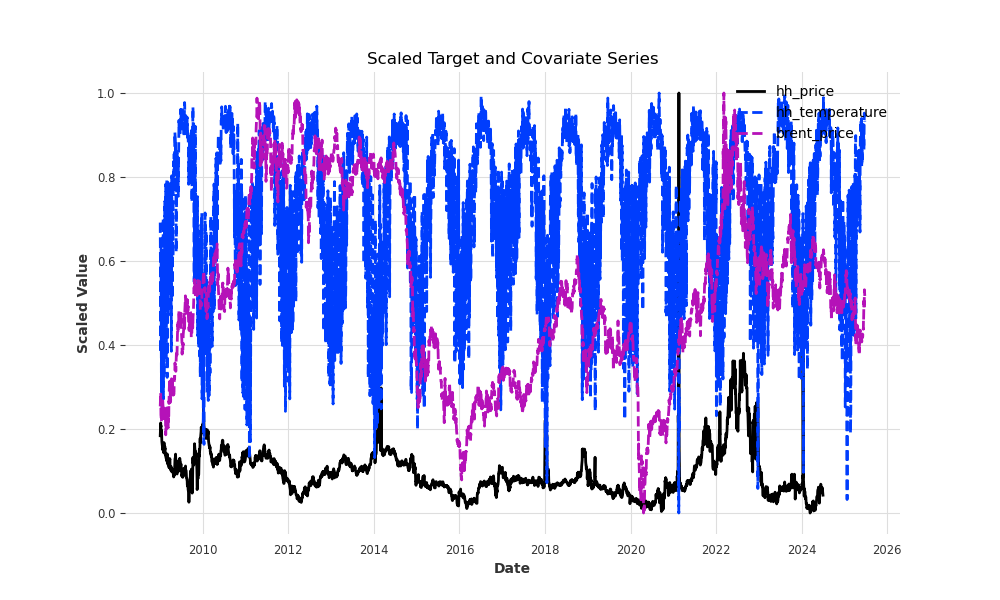

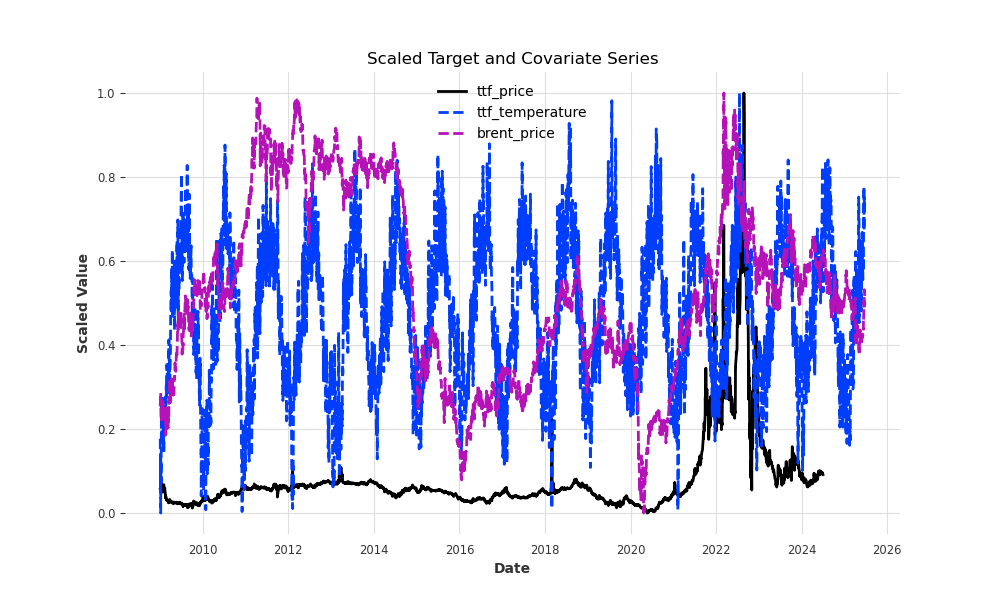

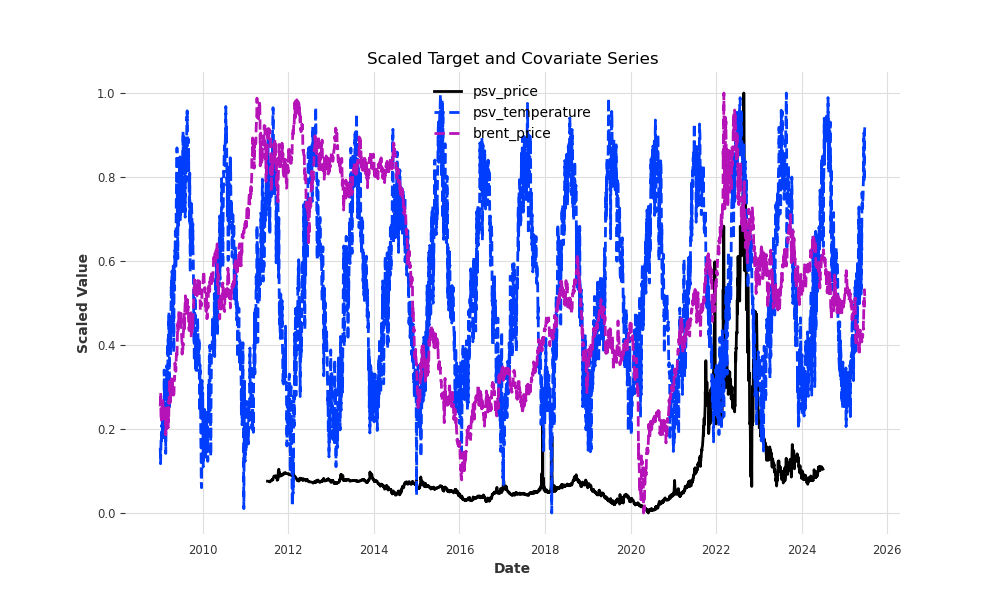

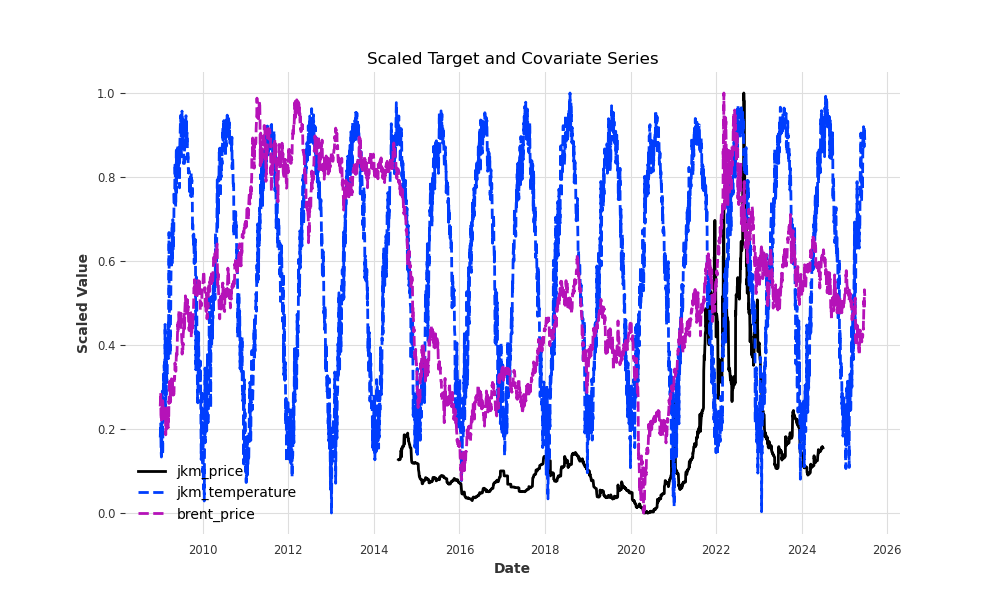

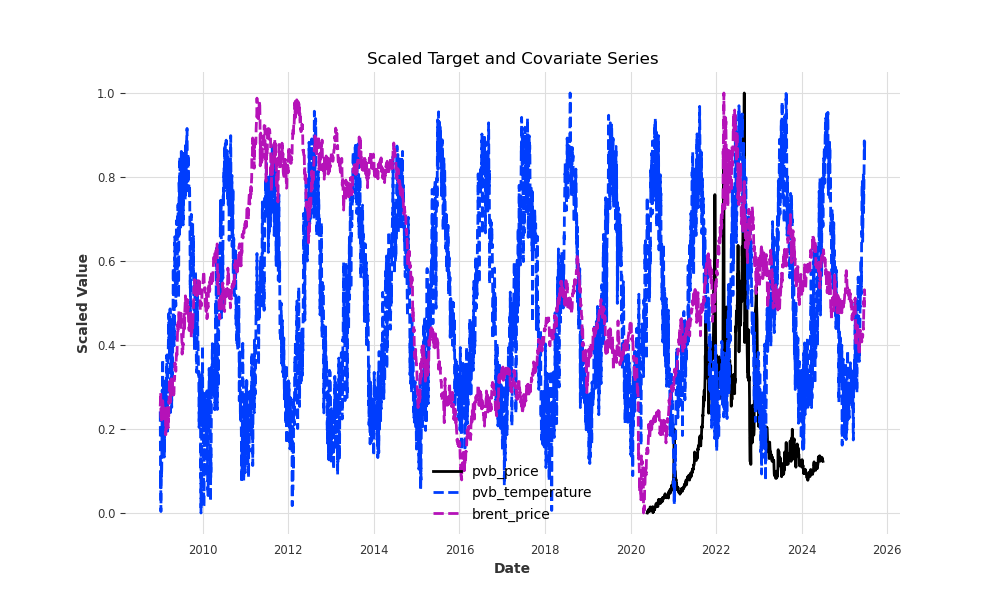

In [4]:
# Plot the scaled target and covariate series
for target_col, covariate_list, (key, covariate_names) in zip(scaled_target_series_train, scaled_covariate_series_dict.values(), covariates.items()):
    plt.figure(figsize=(10, 6))
    target_col.plot(label=key, linestyle='-')
    # Concatenate the list of covariate TimeSeries into one multivariate TimeSeries
    for i, covariate_ts in enumerate(covariate_list):
        covariate_ts.plot(label=covariate_names[i], linestyle='--')
    plt.title(f"Scaled Target and Covariate Series")
    plt.xlabel("Date")
    plt.ylabel("Scaled Value")
    plt.legend()
    plt.show()

# Now working: Plotly plotting the scaled target series adn covariates together
# import plotly.graph_objects as go
# for target_col, covariate in zip(scaled_target_series, scaled_covariate_list):
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=target_col.time_index, y=target_col.values(), mode='lines', name='Target'))
#     fig.add_trace(go.Scatter(x=covariate.time_index, y=covariate.values(), mode='lines', name='Covariates'))
#     fig.update_layout(title='Scaled Target and Covariates', xaxis_title='Date', yaxis_title='Scaled Value')
#     fig.show()

## Fit NBeats global model

In [ ]:
# Step 5: Define and train model
from pytorch_lightning.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="train_loss",
    patience=5,           # Stop after 5 epochs with no improvement
    min_delta=0.0002,     # Minimum change to qualify as improvement
    mode="min"
)
model = NBEATSModel(
    input_chunk_length=252,
    output_chunk_length=30,
    n_epochs=20,
    random_state=42,
    model_name="nbeats_lng_multi",
    save_checkpoints=True,
    force_reset=True,
    num_stacks=2,         # reduce from default
    num_blocks=2,         # reduce from default
    layer_widths=64,       # reduce from default (256)
    log_tensorboard=True,
    add_encoders={"cyclic": {"past": ["month"], "future": ["month"]},
                 },
    pl_trainer_kwargs={
        "callbacks": [early_stopping],  # Add early stopping callback
        "enable_model_summary": True,  # Enable model summary in logs
    }
)

# Train a global model on all targets
model.fit(
    series=scaled_target_series_train[0:5],
    #past_covariates=scaled_covariate_list[0:5],
    val_series=scaled_target_series_val[0:5],  # <-- your validation set
    #val_past_covariates=scaled_covariate_list[0:5],
    verbose=True,
    )

# Plot the log_tensorboard

## Fit TFT

In [ ]:
# TFT model
from darts.models import TFTModel

# Early stopping for TFT model
early_stopping = EarlyStopping(
    monitor="train_loss",
    patience=5,           # Stop after 5 epochs with no improvement
    min_delta=0.001,     # Minimum change to qualify as improvement
    mode="min"
)

# Fit TFT model
# model = TFTModel(
#     input_chunk_length=252,
#     output_chunk_length=30,
#     n_epochs=20,
#     random_state=42,
#     model_name="tft_lng_multi",
#     save_checkpoints=True,
#     force_reset=True,
#     log_tensorboard=True,
#     add_encoders={"cyclic": {"past": ["month"], "future": ["month"]}},
#     pl_trainer_kwargs={
#         "callbacks": [early_stopping],  # Add early stopping callback
#         "enable_model_summary": True,  # Enable model summary in logs
#     }
# )

model = TFTModel(
    input_chunk_length=252,
    output_chunk_length=30,
    n_epochs=20,
    random_state=42,
    optimizer_kwargs={"lr": 1e-3},  # Adjust learning rate
    model_name="tft_lng_multi",
    save_checkpoints=True,
    force_reset=True,
    log_tensorboard=True,
    hidden_size=8,                # reduced from default (16)
    lstm_layers=1,                # keep minimal
    num_attention_heads=2,        # reduced from default (4)
    hidden_continuous_size=4,     # reduced from default (8)
    add_encoders={"cyclic": {"past": ["month"], "future": ["month"]}},
    pl_trainer_kwargs={
        "callbacks": [early_stopping],  # Add early stopping callback
        "enable_model_summary": True,  # Enable model summary in logs
    }
)

# Train a global model on all targets
model.fit(
    series=scaled_target_series_train[0:5],
    #past_covariates=scaled_covariate_list[0:5],
    val_series=scaled_target_series_val[0:5],  # <-- your validation set
    #val_past_covariates=scaled_covariate_list[0:5],
    verbose=True,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.1 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 398    | train
6  | static_context_grn                | _GatedResidualNetwork            | 304    | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=8, lstm_layers=1, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=4, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=252, output_chunk_length=30, n_epochs=20, random_state=42, optimizer_kwargs={'lr': 0.001}, model_name=tft_lng_multi, save_checkpoints=True, force_reset=True, log_tensorboard=True, add_encoders={'cyclic': {'past': ['month'], 'future': ['month']}}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x3943bfc70>], 'enable_model_summary': True})

In [327]:
plt.close('all')  # Close all previous plots

## Plot forecasts 30 days

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

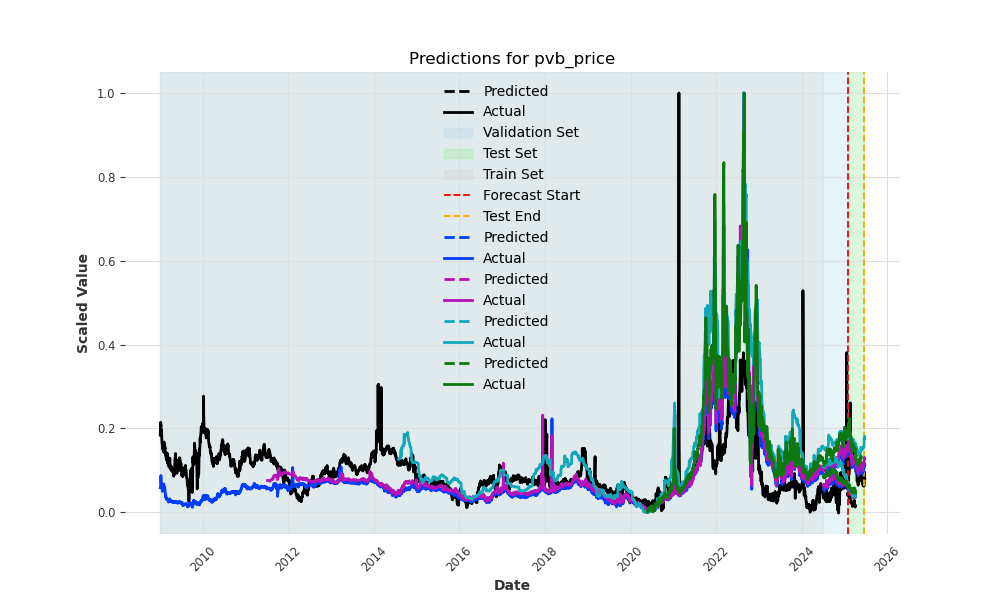

In [ ]:
# Plot the 30 predictions in loop
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default colors from matplotlib

plt.figure(figsize=(10, 6))
for i, t in enumerate(target_cols):
    #forecast = model.predict(n=30, series=scaled_target_series[i])  #, past_covariates=scaled_covariate_list[i])
    forecast = model.predict(n=200, 
                             series=scaled_target_series_train[i], 
                             past_covariates=scaled_covariate_list[i])
    ax = forecast.plot(label='Predicted', linestyle='--', color=colors[i % len(colors)])
    scaled_target_series_all[i].plot(label='Actual', linestyle='-', color=colors[i % len(colors)], ax=ax)
    if i == 0:
        # Plot shaded area for indicating train, validation, and test sets
        plt.axvspan(scaled_target_series_train[i].start_time(), scaled_target_series_val[i].end_time(), color='lightblue', alpha=0.3, label='Validation Set')
        plt.axvspan(scaled_target_series_val[i].end_time(), scaled_target_series_test[i].end_time(), color='lightgreen', alpha=0.3, label='Test Set')
        plt.axvspan(scaled_target_series_train[i].start_time(), scaled_target_series_train[i].end_time(), color='lightgray', alpha=0.3, label='Train Set')
        plt.axvline(scaled_target_series_val[i].end_time(), color='red', linestyle='--', label='Forecast Start')
        plt.axvline(scaled_target_series_test[i].end_time(), color='orange', linestyle='--', label='Test End')
        
plt.xticks(rotation=45)
plt.title(f"Predictions for {t}")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()

plt.show()

In [203]:
print(f"Start date for backtesting: {start_date}")

Start date for backtesting: 2024-05-20 00:00:00


## Plot backtesting

Start date for backtesting: 2024-07-01 00:00:00


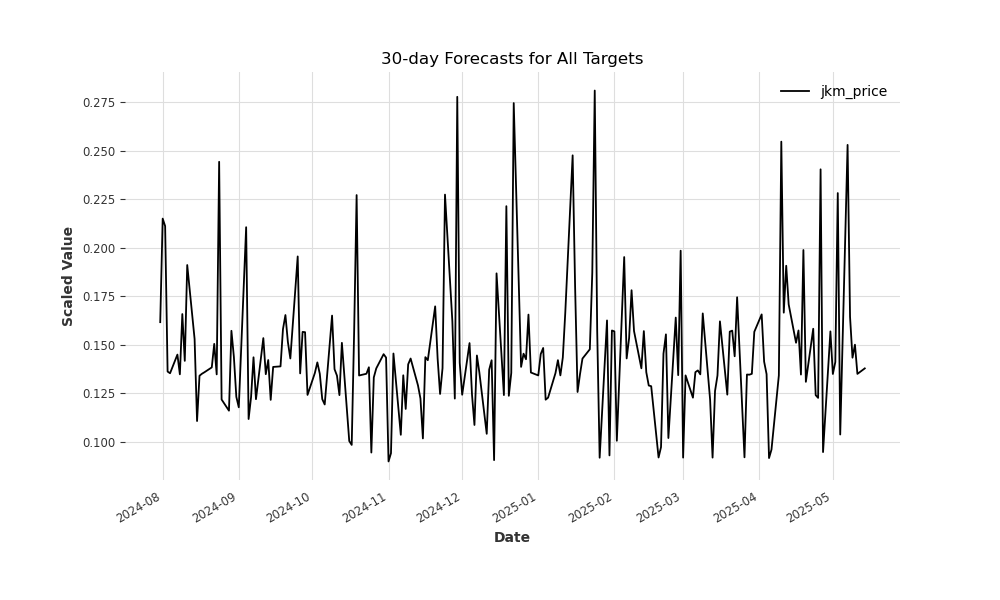

In [102]:
# Backtesting and evaluation
# Set start date so that there are at least 30 days after it for forecasting
# Use the last date in the training set minus forecast_horizon
start_date = scaled_test_series['hh_price'].start_time() #- pd.Timedelta(days=30)
print(f"Start date for backtesting: {start_date}")
forecast_horizon = 30

# backtest_pastcov_per_target = []
# for i in range(len(scaled_test_series['hh_price'])):
#     backtest_pastcov_list = model.historical_forecasts(
#         scaled_target_series_all[0:5],
#         #past_covariates=scaled_covariate_list[0:5],
#         start=scaled_test_series['hh_price'].time_index[i],
#         forecast_horizon=forecast_horizon,
#         stride=1,
#         last_points_only=False,
#         retrain=False,
#         verbose=False,
#     )
#     # Concatenate the list of lists into a list of TimeSeries (one per target)
#     if isinstance(backtest_pastcov_list[0], list):
#         backtest_pastcov_per_target.append([concatenate(ts_list, ignore_time_axis=True) for ts_list in backtest_pastcov_list])
#     else:
#         backtest_pastcov_per_target.append([concatenate(backtest_pastcov_list, ignore_time_axis=True)])

hori30 = []
for list in backtest_pastcov_per_target:
    for l in list:
        hori30.append(l.all_values()[:,0,0][-1])

hori30_all = pd.DataFrame(np.reshape(hori30, (-1,5)), columns=target_cols)
hori30_all['date'] = scaled_test_series['hh_price'].time_index[:206] + pd.Timedelta(days=forecast_horizon)
hori30_all.plot(x='date', y=target_cols[3], title='30-day Forecasts for All Targets', figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.show()

In [90]:
hori30

[]

In [79]:
# Backtesting and evaluation
# Set start date so that there are at least 30 days after it for forecasting
# Use the last date in the training set minus forecast_horizon
start_date = scaled_test_series['hh_price'].start_time() #- pd.Timedelta(days=30)
print(f"Start date for backtesting: {start_date}")
forecast_horizon = 30
backtest_pastcov_list = model.historical_forecasts(
    scaled_target_series_all[0:5],
    #past_covariates=scaled_covariate_list[0:5],
    start=start_date,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

# Concatenate the list of lists into a list of TimeSeries (one per target)
if isinstance(backtest_pastcov_list[0], list):
    backtest_pastcov_per_target = [concatenate(ts_list) for ts_list in backtest_pastcov_list]
else:
    backtest_pastcov_per_target = [concatenate(backtest_pastcov_list)]

# Calculate MAPE, MAE, RMSE and R2
from darts.metrics import mape, mae, rmse, r2_score
scores_dict = {
    "target": target_cols,
    "mape": [],
    "mae": [],
    "rmse": [],
    "r2": []
}
for i, target_col in enumerate(target_cols):
    # Calculate metrics for each target
    mape_value = mape(scaled_target_series_test[i], backtest_pastcov_per_target[i])
    mae_value = mae(scaled_target_series_test[i], backtest_pastcov_per_target[i])
    rmse_value = rmse(scaled_target_series_test[i], backtest_pastcov_per_target[i])
    r2_value = r2_score(scaled_target_series_test[i], backtest_pastcov_per_target[i])

    scores_dict["mape"].append(mape_value)
    scores_dict["mae"].append(mae_value)
    scores_dict["rmse"].append(rmse_value)
    scores_dict["r2"].append(r2_value)

scores_df = pd.DataFrame(scores_dict)
print(scores_df)

Start date for backtesting: 2024-07-01 00:00:00


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/39 [00:00<?, ?it/s]

      target       mape       mae      rmse        r2
0   hh_price  22.522875  0.025439  0.041498 -0.510229
1  ttf_price  20.836218  0.024814  0.032371 -1.328005
2  psv_price  20.937475  0.027551  0.036311 -1.574077
3  jkm_price  15.837672  0.025811  0.033934 -3.190330
4  pvb_price  21.299042  0.035637  0.047310 -1.685379


**Multiple series fit together using NBEATS from Darfs**

**Model Nbeats**
* Reuduced number of parameters (about 20K, was 5M)
```
- No covariates
-- early stopping 0.0001 (full 20 epochs)
       target       mape       mae      rmse        r2
 0   hh_price  37.816013  0.043741  0.053387 -1.499550
 1  ttf_price  19.854406  0.020913  0.024272 -0.308787
 2  psv_price  19.840952  0.023422  0.026919 -0.414716
 3  jkm_price  30.587896  0.046821  0.052658 -9.090466
 4  pvb_price  27.843756  0.039467  0.047715 -1.731546

-- early stopping 0.001 (6 epochs)
       target       mape       mae      rmse        r2
 0   hh_price  28.263292  0.031751  0.042070 -0.552214
 1  ttf_price  21.536657  0.023686  0.027443 -0.673097
 2  psv_price  21.626600  0.026966  0.031176 -0.897547
 3  jkm_price  21.486132  0.033290  0.038223 -4.316483
 4  pvb_price  22.773787  0.035280  0.043008 -1.219180


- Covariates: temperature, brent_price
-- early stopping 0.0001 (17 epochs)
       target       mape       mae      rmse         r2
 0   hh_price  48.474945  0.058341  0.071506  -3.484215
 1  ttf_price  19.941952  0.025624  0.034827  -1.694612
 2  psv_price  16.523012  0.023808  0.034382  -1.307832
 3  jkm_price  27.389532  0.046805  0.056166 -10.479772
 4  pvb_price  31.052124  0.055551  0.068382  -4.610216

 -- early stopping 0.001 (5 epochs)
        target       mape       mae      rmse        r2
 0   hh_price  49.018738  0.056565  0.065561 -2.769588
 1  ttf_price  22.697035  0.029670  0.041776 -2.877257
 2  psv_price  21.098021  0.030331  0.043123 -2.630445
 3  jkm_price  22.974047  0.039499  0.049197 -7.807755
 4  pvb_price  27.560089  0.048806  0.060303 -3.362871

```

**Model TFT**
* Default parameters 19K (showing noisy fit curve)
```
- No covariates
-- early stopping 0.001, lr=1e-3(?) (10 epochs)
       target       mape       mae      rmse        r2
 0   hh_price  28.712334  0.030076  0.039436 -0.363902
 1  ttf_price  18.288387  0.020396  0.025579 -0.453528
 2  psv_price  16.080902  0.021011  0.027321 -0.457206
 3  jkm_price  21.429379  0.034072  0.042002 -5.419700
 4  pvb_price  20.110653  0.032409  0.038079 -0.739660

-- early stopping 0.001, lr=1e-3 (7 epochs)
       target       mape       mae      rmse        r2
0   hh_price  22.522875  0.025439  0.041498 -0.510229
1  ttf_price  20.836218  0.024814  0.032371 -1.328005
2  psv_price  20.937475  0.027551  0.036311 -1.574077
3  jkm_price  15.837672  0.025811  0.033934 -3.190330
4  pvb_price  21.299042  0.035637  0.047310 -1.685379

- Covariates: temperature, brent_price
-- no early stopping (20 epochs)
      target       mape       mae      rmse        r2
 0   hh_price  26.126703  0.028484  0.039144 -0.343777
 1  ttf_price  15.728547  0.019110  0.024697 -0.355105
 2  psv_price  16.399725  0.022500  0.029599 -0.710442
 3  jkm_price  24.349981  0.040539  0.046217 -6.772864
 4  pvb_price  25.488026  0.044040  0.051779 -2.216628

```
* Small model: 5.4K parameters (8-1-2-4)
```
- No covariates
-- early stopping 0.001 (9 epochs)
     target       mape       mae      rmse        r2
0   hh_price  21.730133  0.025587  0.038292 -0.285946
1  ttf_price  18.559626  0.022310  0.029889 -0.984738
2  psv_price  18.862408  0.025272  0.032454 -1.056198
3  jkm_price  16.619265  0.026928  0.037644 -4.156713
4  pvb_price  18.054876  0.031027  0.039060 -0.830454

```

* Smaller: 1.8K parameters (4-1-1-2)
```
- No covariates
-- early stopping 0.001 (12 epochs)
      target       mape       mae      rmse         r2
0   hh_price  77.013573  0.082526  0.108045  -9.237827
1  ttf_price  72.509132  0.082704  0.101315 -21.804382
2  psv_price  63.878208  0.080593  0.097337 -17.496906
3  jkm_price  52.349060  0.085142  0.094920 -31.786404
4  pvb_price  61.181358  0.101889  0.117401 -15.536364
```

`start` time `2009-01-02 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2009-12-22 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAPE for hh_price: 22.52%


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`start` time `2009-01-02 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2009-12-22 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAPE for ttf_price: 20.84%


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`start` time `2011-07-07 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2012-06-25 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAPE for psv_price: 20.94%


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`start` time `2014-07-29 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2015-07-16 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAPE for jkm_price: 15.84%


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`start` time `2020-05-22 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2021-05-11 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MAPE for pvb_price: 21.30%


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

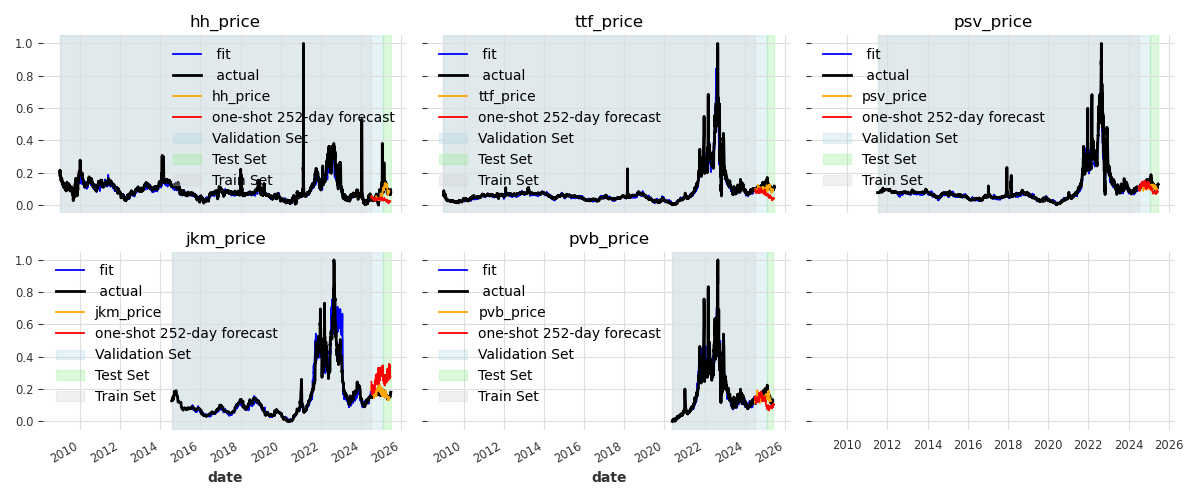

In [84]:
# Plot the backtest results in on figure
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default colors from matplotlib
# plt.figure(figsize=(10, 6))
# for i, name in enumerate(target_cols):
#     print(f"MAPE for {name}: {mape(scaled_target_series_train_test[i], backtest_pastcov_per_target[i]):.2f}%")
#     color = colors[i % len(colors)]
#     # Plot actual and forecast
#     scaled_target_series_train_test[i].plot(label=name+" actual", linestyle='-', color=color)
#     backtest_pastcov_per_target[i].plot(label=name+" forecast NBeats", linestyle='--', color=color)

# plt.title(f"Backtest Forecast")
# plt.xlabel("Date")
# plt.ylabel("Scaled Value")
# plt.legend()
# plt.show()

# Plot in different subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)

for i, name in enumerate(target_cols[0:5]):
    axs[i // 3, i % 3].set_title(f"Backtest Forecast for {name}")
    axs[i // 3, i % 3].set_xlabel("Date")
    axs[i // 3, i % 3].set_ylabel("Scaled Value")
    print(f"MAPE for {name}: {mape(scaled_target_series_test[i], backtest_pastcov_per_target[i]):.2f}%")

    # Predict on the training set (fit curve)
    fit_pred = model.historical_forecasts(
        scaled_target_series_train[i],
        #past_covariates=scaled_covariate_list[i],
        start=scaled_target_series_train[i].start_time(),
        forecast_horizon=1,
        stride=1,
        last_points_only=True,
        retrain=False,
        verbose=False,
    )
    # Plot fit, actual and forecast with smoothing
    axs[i // 3, i % 3].plot(fit_pred.time_index, pd.Series(fit_pred.all_values()[:,0,0]).rolling(window=7, center=True).mean(), label=" fit", linestyle='-', color='blue')
    scaled_target_series_all[i].plot(label=" actual", linestyle='-', color='black', ax=axs[i // 3, i % 3])
    backtest_pastcov_per_target[i].to_dataframe().rolling(window=7, center=True).mean().plot(label=" 30-day-chunks forecast", linestyle='-', color='orange', ax=axs[i // 3, i % 3])

    fit_pred = model.predict(n=252, 
                             series=scaled_target_series_train[i], 
                             #past_covariates=scaled_covariate_list[i]
                             )
    axs[i // 3, i % 3].plot(fit_pred.time_index, pd.Series(fit_pred.all_values()[:,0,0]).rolling(window=7, center=True).mean(), label="one-shot 252-day forecast", linestyle='-', color='red')


    # Plot fit, actual and forecast
    # axs[i // 3, i % 3].plot(fit_pred.time_index, fit_pred.all_values()[:,0,0], label=" fit", linestyle='-', color='blue')
    # scaled_target_series_all[i].plot(label=" actual", linestyle='-', color='black', ax=axs[i // 3, i % 3])
    # backtest_pastcov_per_target[i].plot(label=" 30-day-chunks forecast", linestyle='-', color='orange', ax=axs[i // 3, i % 3])


    # fit_pred = model.predict(n=252, 
    #                          series=scaled_target_series_train[i], 
    #                          #past_covariates=scaled_covariate_list[i]
    #                          )
    # axs[i // 3, i % 3].plot(fit_pred.time_index, fit_pred.all_values()[:,0,0], label="one-shot 252-day forecast", linestyle='-', color='red')

    # Plot shaded area for indicating train, validation, and test sets
    axs[i // 3, i % 3].axvspan(scaled_target_series_train[i].start_time(), scaled_target_series_val[i].end_time(), color='lightblue', alpha=0.3, label='Validation Set')
    axs[i // 3, i % 3].axvspan(scaled_target_series_val[i].end_time(), scaled_target_series_test[i].end_time(), color='lightgreen', alpha=0.3, label='Test Set')
    axs[i // 3, i % 3].axvspan(scaled_target_series_train[i].start_time(), scaled_target_series_train[i].end_time(), color='lightgray', alpha=0.3, label='Train Set')
    axs[i // 3, i % 3].legend()
    axs[i // 3, i % 3].set_title(f"{name}")

plt.tight_layout()
plt.show()

# # Plot in different subplots of inverse scaled values
# fig, axs = plt.subplots(2, 3, figsize=(12, 1 * len(target_cols)), sharex=True, sharey=False)

# for i, name in enumerate(target_cols):
#     axs[i // 3, i % 3].set_title(f"Backtest Forecast for {name}")
#     axs[i // 3, i % 3].set_xlabel("Date")
#     axs[i // 3, i % 3].set_ylabel("Scaled Value")
#     print(f"MAPE for {name}: {mape(scaled_target_series_train_test[i], backtest_pastcov_per_target[i]):.2f}%")

#     # Predict on the training set (fit curve)
#     fit_pred = model.historical_forecasts(
#         scaled_target_series[i],
#         past_covariates=scaled_covariate_list[i],
#         start=scaled_target_series[i].start_time(),
#         forecast_horizon=1,
#         stride=1,
#         last_points_only=True,
#         retrain=False,
#         verbose=False,
#     )
    
#     # Plot fit, actual and forecast
#     axs[i // 3, i % 3].plot(fit_pred.time_index, scaler_dict[name].inverse_transform(fit_pred).all_values()[:,0,0], label=name+" fit", linestyle='-', color='blue')
#     scaler_dict[name].inverse_transform(scaled_target_series_train_test[i]).plot(label=name+" actual", linestyle='-', color='black', ax=axs[i // 3, i % 3])
#     scaler_dict[name].inverse_transform(backtest_pastcov_per_target[i]).plot(label=name+" forecast NBeats", linestyle='--', color='orange', ax=axs[i // 3, i % 3])
#     axs[i // 3, i % 3].legend()

# plt.tight_layout()
# plt.show()

# Plot in different subplots
# fig, axs = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)

# for i, name in enumerate(target_cols[0:5]):
#     axs[i // 3, i % 3].set_title(f"Backtest Forecast for {name}")
#     axs[i // 3, i % 3].set_xlabel("Date")
#     axs[i // 3, i % 3].set_ylabel("Scaled Value")
    
#     fit_pred = model.predict(n=252, 
#                              series=scaled_target_series_train[i], 
#                              past_covariates=scaled_covariate_list[i]
#                              )

#     # Plot fit, actual and forecast
#     axs[i // 3, i % 3].plot(fit_pred.time_index, fit_pred.all_values()[:,0,0], label="(one-shot 252-day forecast)", linestyle='-', color='blue')
#     scaled_target_series_all[i].plot(label=" actual", linestyle='-', color='black', ax=axs[i // 3, i % 3])
#     backtest_pastcov_per_target[i].plot(label=" forecast (30-day chunks)", linestyle='--', color='orange', ax=axs[i // 3, i % 3])

#     # Plot shaded area for indicating train, validation, and test sets
#     axs[i // 3, i % 3].axvspan(scaled_target_series_train[i].start_time(), scaled_target_series_val[i].end_time(), color='lightblue', alpha=0.3, label='Validation Set')
#     axs[i // 3, i % 3].axvspan(scaled_target_series_val[i].end_time(), scaled_target_series_test[i].end_time(), color='lightgreen', alpha=0.3, label='Test Set')
#     axs[i // 3, i % 3].axvspan(scaled_target_series_train[i].start_time(), scaled_target_series_train[i].end_time(), color='lightgray', alpha=0.3, label='Train Set')
    
#     axs[i // 3, i % 3].legend()
#     axs[i // 3, i % 3].set_title(f"{name}")

# plt.tight_layout()
# plt.show()

## Train different nbeats models for each

In [320]:
# Print the shape of the target and covariate series
for i, target_col in enumerate(target_cols):
    # print the shape of the target and covariate series
    print(f"Shape of target and covariate series for {target_col}: {scaled_target_series[i].shape} and {scaled_covariate_list[i].shape}")

Shape of target and covariate series for hh_price: (4042, 1, 1) and (4297, 3, 1)
Shape of target and covariate series for ttf_price: (4042, 1, 1) and (4297, 3, 1)
Shape of target and covariate series for psv_price: (3388, 1, 1) and (4146, 5, 1)
Shape of target and covariate series for jkm_price: (2590, 1, 1) and (3643, 6, 1)
Shape of target and covariate series for pvb_price: (1072, 1, 1) and (2845, 7, 1)


In [323]:
from time import sleep

# Train different models for each target
models = {key: None for key in target_cols}

for i, target_col in enumerate(target_cols):# enumerate(['ttf_price']):
    # Create a new model instance for each target
    model = NBEATSModel(
        input_chunk_length=252,
        output_chunk_length=30,
        n_epochs=1,
        random_state=42,
        model_name=f"nbeats_{target_col}",
        save_checkpoints=True,
        force_reset=True,
        num_stacks=2,         # reduce from default
        num_blocks=2,         # reduce from default
        layer_widths=64,       # reduce from default (256)
    )
    # print the shape of the target and covariate series
    print(f"Shape of target and covariate series for {target_col}: {scaled_target_series[i].shape}, {scaled_covariate_list[i].shape}")
    print(f"Training for {target_col}...")
    model.fit(
        series=scaled_target_series[i],
        past_covariates=scaled_covariate_list[i],
        verbose=True,
    )
    models[target_col] = model

    sleep(5)  # Sleep to avoid too many logs in TensorBoard


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 337 K  | train
-------------------------------------------------------------
331 K     Trainable params
6.4 K     Non-trainable params
337 K     Total params
1.352     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Shape of target and covariate series for hh_price: (4042, 1, 1), (4297, 3, 1)
Training for hh_price...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 337 K  | train
-------------------------------------------------------------
331 K     Trainable params
6.4 K     Non-trainable params
337 K     Total params
1.352     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Shape of target and covariate series for ttf_price: (4042, 1, 1), (4297, 3, 1)
Training for ttf_price...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 480 K  | train
-------------------------------------------------------------
471 K     Trainable params
9.4 K     Non-trainable params
480 K     Total params
1.922     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Shape of target and covariate series for psv_price: (3388, 1, 1), (4146, 5, 1)
Training for psv_price...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 551 K  | train
-------------------------------------------------------------
540 K     Trainable params
10.9 K    Non-trainable params
551 K     Total params
2.207     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Shape of target and covariate series for jkm_price: (2590, 1, 1), (3643, 6, 1)
Training for jkm_price...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 623 K  | train
-------------------------------------------------------------
610 K     Trainable params
12.4 K    Non-trainable params
623 K     Total params
2.492     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Shape of target and covariate series for pvb_price: (1072, 1, 1), (2845, 7, 1)
Training for pvb_price...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
